In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
books = pd.read_csv("../data/Books.csv", low_memory=False)
users = pd.read_csv("../data/Users.csv")
ratings = pd.read_csv("../data/Ratings.csv")

In [3]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In [4]:
print("Missing values in Books Dataset:")
print(books.isnull().sum(), "\n")

print("Missing values in Users Dataset:")
print(users.isnull().sum(), "\n")

print("Missing values in Ratings Dataset:")
print(ratings.isnull().sum())

Missing values in Books Dataset:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64 

Missing values in Users Dataset:
User-ID          0
Location         0
Age         110762
dtype: int64 

Missing values in Ratings Dataset:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [5]:
book_counts = ratings['ISBN'].value_counts()
books_to_keep = book_counts[book_counts >= 20].index

# Step 2: Filter users with at least 50 reviews
user_counts = ratings['User-ID'].value_counts()
users_to_keep = user_counts[user_counts >= 50].index

# Step 3: Filter the original DataFrame
ratings = ratings[
    (ratings['ISBN'].isin(books_to_keep)) &
    (ratings['User-ID'].isin(users_to_keep))
]

ratings["User-ID"].value_counts()

User-ID
11676     3484
35859     1560
76352     1329
153662    1300
16795     1075
          ... 
148154       1
2442         1
24624        1
102532       1
196898       1
Name: count, Length: 3382, dtype: int64

In [6]:
duplicates = books[books.duplicated(subset='ISBN', keep=False)]
print(duplicates[['ISBN', 'Book-Title']].sort_values('ISBN'))


Empty DataFrame
Columns: [ISBN, Book-Title]
Index: []


In [7]:
# Merge ratings with books to get titles
merged = ratings.merge(books[['ISBN', 'Book-Title']], on='ISBN', how='left')
merged = merged.merge(users[['User-ID', 'Location', 'Age']], on='User-ID', how='left')

In [8]:
avg_ratings = merged.groupby("Book-Title")["Book-Rating"].mean()
rating_counts = merged.groupby("Book-Title")["Book-Rating"].count()

book_stats = pd.DataFrame({
    "Average Rating": avg_ratings,
    "Number of Reviews": rating_counts
})

filtered_books = book_stats[book_stats["Number of Reviews"] >= 30]
top_books = filtered_books.sort_values(by="Average Rating", ascending=False)

print(top_books.head(10))

                                                    Average Rating  \
Book-Title                                                           
Griffin &amp; Sabine: An Extraordinary Correspo...        6.461538   
Harry Potter and the Chamber of Secrets Postcar...        6.027778   
The Golden Mean: In Which the Extraordinary Cor...        5.875000   
Harry Potter and the Sorcerer's Stone (Book 1)            5.660256   
The Little Prince                                         5.606061   
Homicidal Psycho Jungle Cat: A Calvin and Hobbe...        5.566667   
Sabine's Notebook: In Which the Extraordinary C...        5.431818   
Harry Potter and the Prisoner of Azkaban (Book 3)         5.407407   
The Stand (The Complete and Uncut Edition)                5.400000   
Harry Potter and the Goblet of Fire (Book 4)              5.370536   

                                                    Number of Reviews  
Book-Title                                                             
Griffin &amp; S

/var/folders/wn/y0pb2sm10lvg7s176rdg7yg80000gn/T/ipykernel_3444/890718739.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=6)
/var/folders/wn/y0pb2sm10lvg7s176rdg7yg80000gn/T/ipykernel_3444/890718739.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=6)


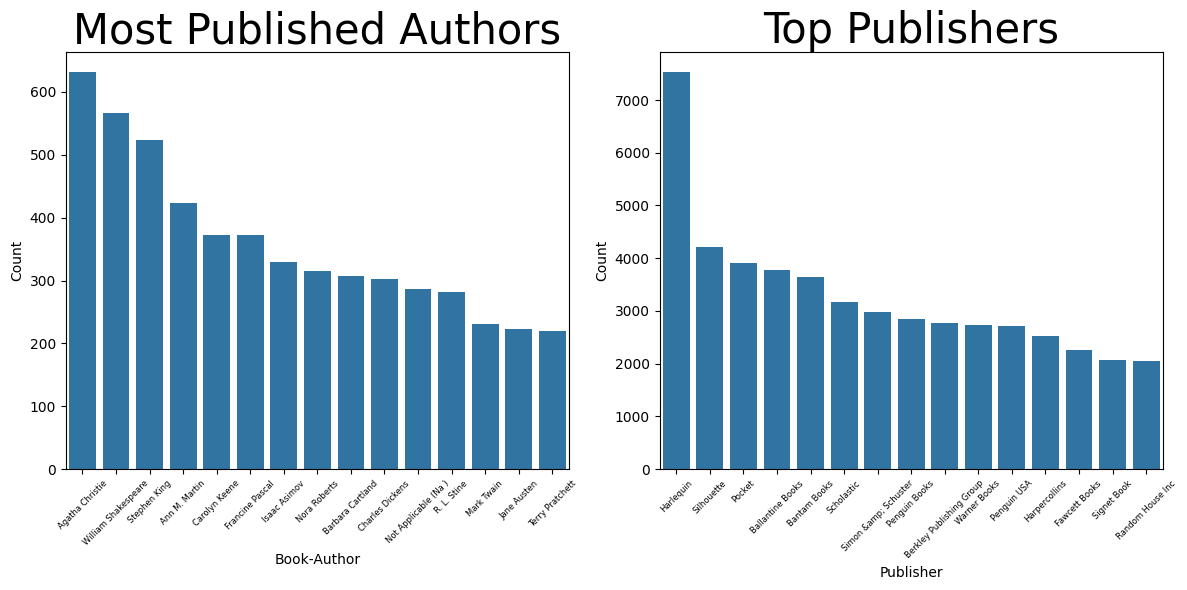

In [9]:
author_count = books['Book-Author'].value_counts().reset_index(name='Count').sort_values('Count', ascending=False).head(15)

publisher_count = books['Publisher'].value_counts().reset_index(name='Count').sort_values('Count', ascending=False).head(15)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=author_count, x='Book-Author', y='Count', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=6)
ax1.set_title('Most Published Authors', size=30)

ax2 = sns.barplot(data=publisher_count, x='Publisher', y='Count', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=6)
ax2.set_title('Top Publishers', size=30)

plt.tight_layout()

/var/folders/wn/y0pb2sm10lvg7s176rdg7yg80000gn/T/ipykernel_3444/3813032705.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('RdYlGn_r', 10)


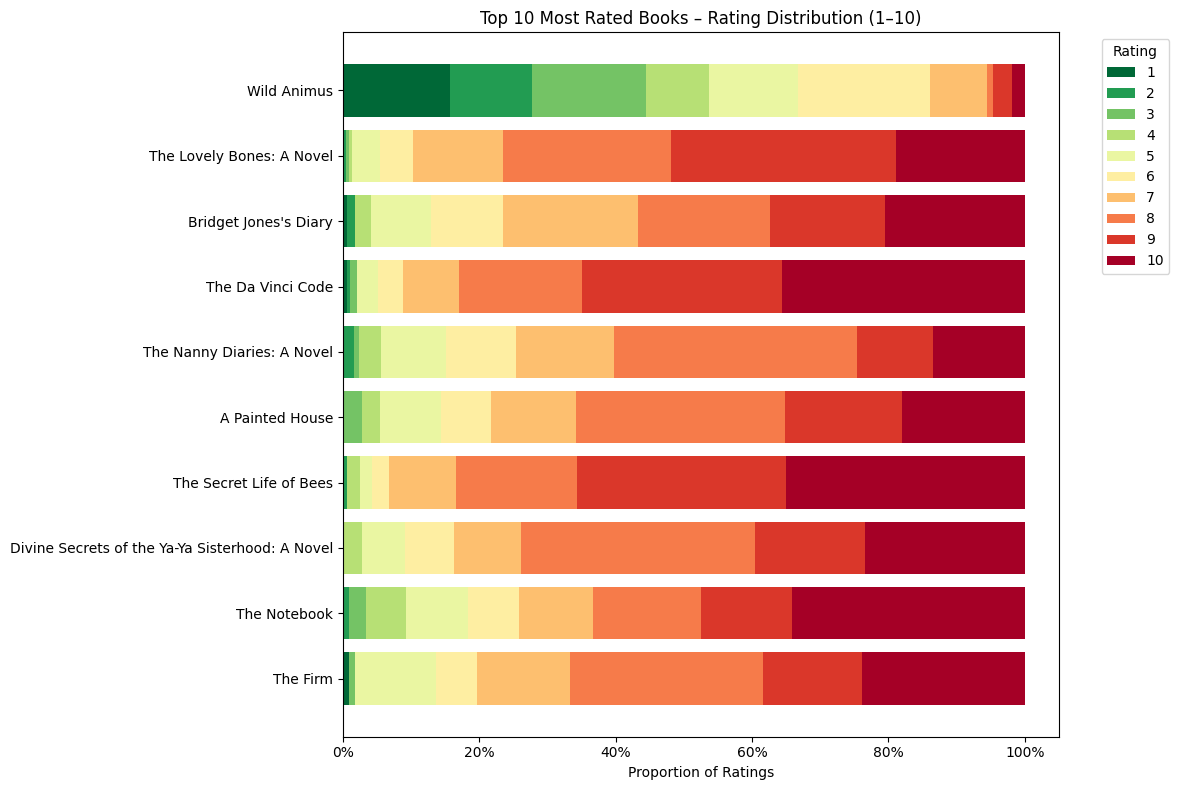

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

top_counts = merged['Book-Title'].value_counts().head(10)
top_titles = top_counts.index

rating_scale = list(range(1, 11))

dist = (
    merged[merged['Book-Title'].isin(top_titles)]
      .groupby('Book-Title')['Book-Rating']
      .value_counts()
      .unstack(fill_value=0)
      .reindex(columns=rating_scale, fill_value=0)
      .loc[top_titles]
)

prop = dist.div(dist.sum(axis=1), axis=0)

cmap = mpl.cm.get_cmap('RdYlGn_r', 10)
colors = [cmap(i) for i in range(cmap.N)]

plt.figure(figsize=(12, 8))
bottom = np.zeros(len(prop))

for rating_val, color in zip(rating_scale, colors):
    segment = prop[rating_val]
    plt.barh(prop.index, segment, left=bottom, color=color, label=str(rating_val))
    bottom += segment

plt.gca().invert_yaxis()
plt.xlabel('Proportion of Ratings')
plt.title('Top 10 Most Rated Books – Rating Distribution (1–10)')
plt.gca().set_xticks(np.linspace(0, 1, 6))
plt.gca().set_xticklabels([f'{int(x*100)}%' for x in np.linspace(0, 1, 6)])
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/wn/y0pb2sm10lvg7s176rdg7yg80000gn/T/ipykernel_3444/2428778937.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=ratings, palette='viridis')


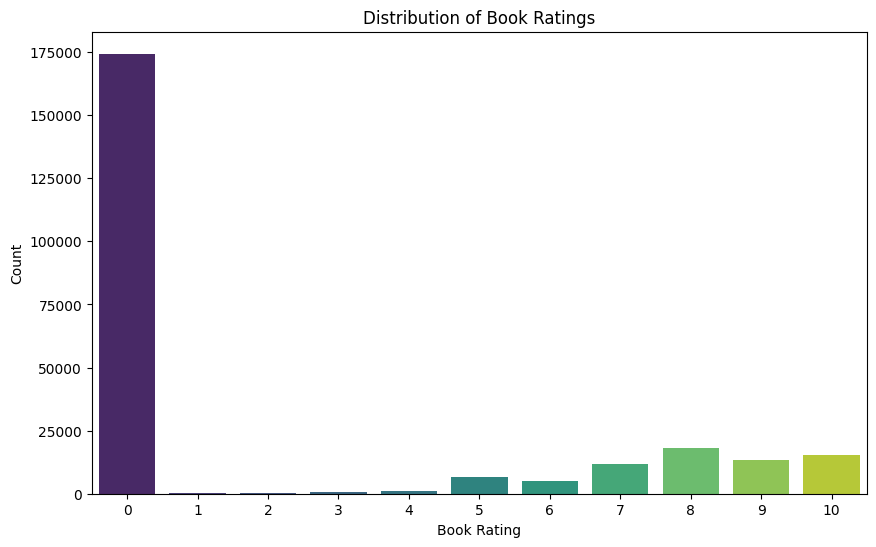

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=ratings, palette='viridis')
plt.title("Distribution of Book Ratings")
plt.xlabel("Book Rating")
plt.ylabel("Count")
plt.show()